In [543]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from sklearn.cluster import KMeans
import random as rand
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.dates as md
from sklearn.neighbors import LocalOutlierFactor
plt.style.use('ggplot')


In [544]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

In [545]:
def estimateGaussian(X):
    m = X.shape[0]
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = (sum_/m)
    # compute variance of X
    var = np.var(X,axis=0)
    print(mu, var)
    return mu,var

In [546]:
def multivariateGaussian(X, mu, sigma):
    k = len(mu)
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p

In [547]:
PATH =   r"data/realAWSCloudwatch/realAWSCloudwatch/"

df = pd.read_csv(PATH+"ec2_cpu_utilization_5f5533.csv")
outliers_fraction=0.01
rand.seed(666)

In [548]:
df.describe

<bound method NDFrame.describe of                 timestamp   value
0     2014-02-14 14:27:00  51.846
1     2014-02-14 14:32:00  44.508
2     2014-02-14 14:37:00  41.244
3     2014-02-14 14:42:00  48.568
4     2014-02-14 14:47:00  46.714
...                   ...     ...
4027  2014-02-28 14:02:00  38.474
4028  2014-02-28 14:07:00  40.352
4029  2014-02-28 14:12:00  37.912
4030  2014-02-28 14:17:00  38.458
4031  2014-02-28 14:22:00  37.718

[4032 rows x 2 columns]>

In [549]:
print(df['value'].mean())
print(df['value'].median())

43.11037160218254
42.918


In [550]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

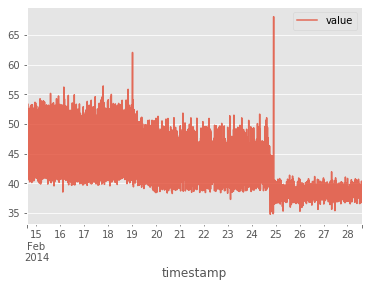

In [596]:
df.plot(x='timestamp', y='value', alpha=0.8)

In [552]:
data = df[['time_epoch','value']]

In [553]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

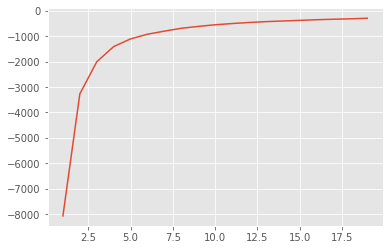

In [554]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [555]:
df['cluster'] = kmeans[3].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

3    1268
1    1167
0     913
2     684
Name: cluster, dtype: int64

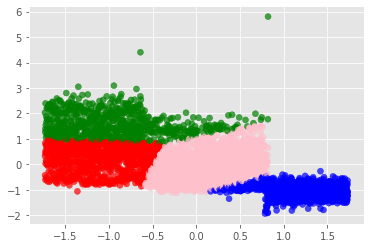

In [594]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]), alpha=0.7)
plt.show()
# Cant detect outlier as expected

In [557]:
## DISTANCE BASED

In [558]:
distance = getDistanceByPoint(data, kmeans[3])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

df['anomaly'] = (distance >= threshold).astype(int)

d:\academics\software\python\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


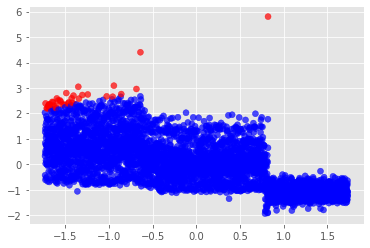

In [593]:
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly"].apply(lambda x: colors[x]), alpha=0.7)
plt.show()

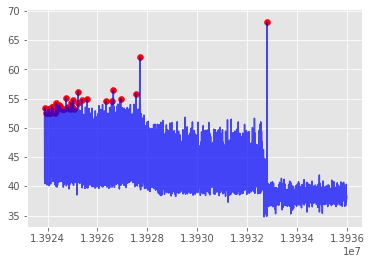

In [590]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue', alpha=0.7)
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

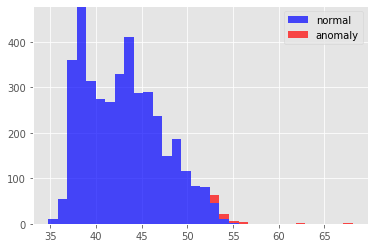

In [589]:
a = df.loc[df['anomaly'] == 0, 'value']
b = df.loc[df['anomaly'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'], alpha=0.7)
plt.legend()
plt.show()

In [562]:
# X = df['value'].to_numpy()
# (mu, sigma)= estimateGaussian(X)
# p = multivariateGaussian(X, [mu], [sigma])

In [563]:
## GAUSSIAN BASED

In [564]:
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df['value'].values.reshape(-1,1)
envelope.fit(X_train)
df_class = pd.DataFrame(df['value'])
df_class['deviation'] = envelope.decision_function(X_train)
df_class['anomaly'] = envelope.predict(X_train)
df_class['time_epoch'] = df['time_epoch']

df['anomalyGauss'] = df_class['anomaly']
df['anomalyGauss'] = np.array(df['anomalyGauss'] == -1).astype(int) 

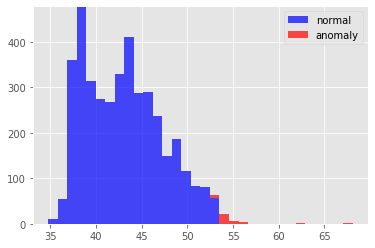

In [588]:
a = df_class.loc[df_class['anomaly'] == 1, 'value']
b = df_class.loc[df_class['anomaly'] == -1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'], alpha=0.7);
plt.legend()
plt.show()

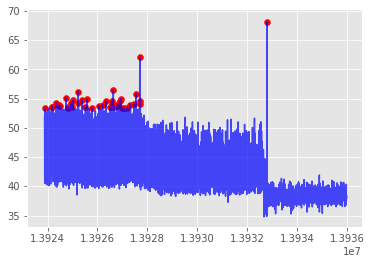

In [587]:
fig, ax = plt.subplots()

a = df.loc[df['anomalyGauss'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue', alpha=0.7)
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

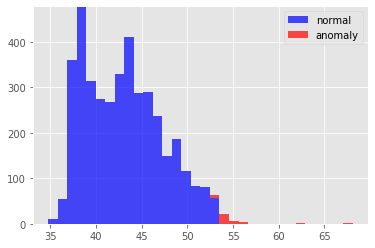

In [586]:
a = df.loc[df['anomalyGauss'] == 0, 'value']
b = df.loc[df['anomalyGauss'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'], alpha=0.7)
plt.legend()
plt.show()

In [568]:
# ISOLATION FOREST

In [569]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

d:\academics\software\python\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
d:\academics\software\python\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0    3991
1      41
Name: anomaly25, dtype: int64


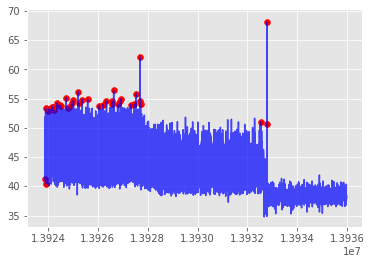

In [585]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue', alpha=0.7)
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

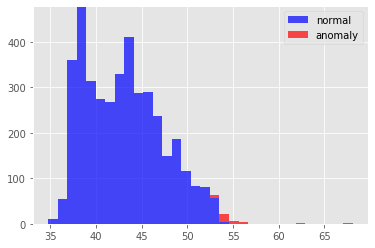

In [584]:
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'], alpha=0.7)
plt.legend()
plt.show()

In [572]:
# SVM

In [573]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    3991
1      41
Name: anomaly26, dtype: int64


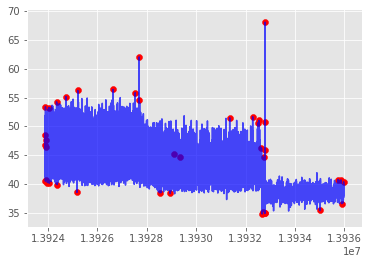

In [583]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue', alpha=0.7)
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

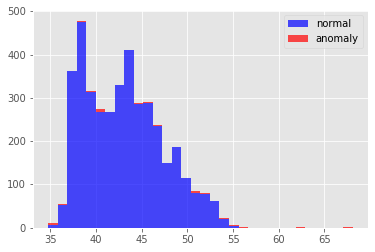

In [575]:
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'], alpha=0.7)
plt.legend()
plt.show()

In [576]:
# Local outlier Factor

In [577]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomalyLOF'] = pd.Series(model.predict(data))
df['anomalyLOF'] = df['anomalyLOF'].map( {1: 0, -1: 1} )
print(df['anomalyLOF'].value_counts())

0    3696
1     336
Name: anomalyLOF, dtype: int64


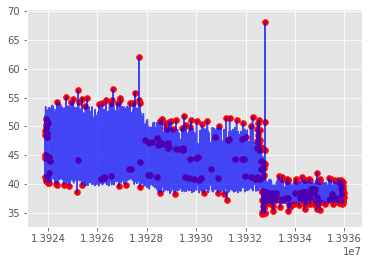

In [597]:
fig, ax = plt.subplots()

a = df.loc[df['anomalyLOF'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue', alpha=0.7)
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

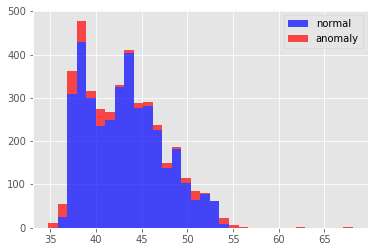

In [598]:
a = df.loc[df['anomalyLOF'] == 0, 'value']
b = df.loc[df['anomalyLOF'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'], alpha=0.7)
plt.legend()
plt.show()

In [580]:
# RNN

In [581]:
# min_max_scaler = preprocessing.StandardScaler()
# data_n = data
# np_scaled = min_max_scaler.fit_transform(data_n)
# data_n = pd.DataFrame(np_scaled)

# # important parameters and train/test size
# prediction_time = 1 
# testdatasize = 1000
# unroll_length = 50
# testdatacut = testdatasize + unroll_length  + 1

# #train data
# x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
# y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

# # test data
# x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
# y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

In [582]:
# def unroll(data,sequence_length=24):
#     result = []
#     for index in range(len(data) - sequence_length):
#         result.append(data[index: index + sequence_length])
#     return np.asarray(result)

# # adapt the datasets for the sequence data shape
# x_train = unroll(x_train,unroll_length)
# x_test  = unroll(x_test,unroll_length)
# y_train = y_train[-x_train.shape[0]:]
# y_test  = y_test[-x_test.shape[0]:]

# # see the shape
# print("x_train", x_train.shape)
# print("y_train", y_train.shape)
# print("x_test", x_test.shape)
# print("y_test", y_test.shape)